In [3]:
#必要なライブラリのインポート
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [5]:
#データのインポート
teams=pd.read_csv("data/teams.csv")
boxscore=pd.read_csv("data/games_boxscore_202021.csv")

In [7]:
#teamsからB1 2020-21シーズンのデータだけ抜き出す
teams=teams[teams["League"]=="B1"]
teams=teams[teams["Season"]=="2020-21"]

,TeamId,Season,League,NameShort,NameLong,Division
144,702,2020-21,B1,北海道,レバンガ北海道,東地区
145,693,2020-21,B1,秋田,秋田ノーザンハピネッツ,東地区
146,703,2020-21,B1,宇都宮,宇都宮ブレックス,東地区
147,704,2020-21,B1,千葉,千葉ジェッツ,東地区
148,706,2020-21,B1,A東京,アルバルク東京,東地区
149,726,2020-21,B1,SR渋谷,サンロッカーズ渋谷,東地区
150,727,2020-21,B1,川崎,川崎ブレイブサンダース,東地区
151,694,2020-21,B1,横浜,横浜ビー・コルセアーズ,東地区
152,695,2020-21,B1,新潟,新潟アルビレックスBB,東地区
153,696,2020-21,B1,富山,富山グラウジーズ,東地区


In [9]:
#boxscoreからB1のデータだけ抜き出す
boxscore=teams.merge(boxscore,on="TeamId")

In [16]:
#MINでPTSを回帰する線形回帰モデルを立てる
model=LinearRegression()
model.fit(boxscore[["MIN"]],boxscore[["PTS"]])
model.score(boxscore[["MIN"]],boxscore[["PTS"]])#モデルの決定係数の確認：0.549

0.5492231633504231

In [37]:
#モデルの残差を得る
PRED=model.predict(boxscore[["MIN"]])
RES=[]
for pts,pred in zip(boxscore["PTS"],PRED):
    RES.append(pts-pred)
    
boxscore["res"]=pd.DataFrame(RES)

In [39]:
#残差を選手ごとに集計
avg=boxscore.groupby("Player").mean()
std=boxscore.groupby("Player").std()

In [40]:
#インデックスのリセット
avg=avg.reset_index()
std=std.reset_index()

In [44]:
#avg,stdから必要な列だけ抜き出す
avg=avg.loc[:,["Player","PTS","MIN","res"]]
std=std.loc[:,["Player","res"]]

In [46]:
#avgとstdを結合する
data=avg.merge(std,on="Player",suffixes=["_avg","_std"])

In [49]:
#残差の要約統計量を確認：残差の平均から
data["res_avg"].describe()

count    302.000000
mean       0.141429
std        2.529207
min       -6.699907
25%       -1.626052
50%       -0.029041
75%        1.437906
max        8.860032
Name: res_avg, dtype: float64

In [51]:
#残差の要約統計量を確認：標準偏差
data["res_std"].describe()

count    301.000000
mean       3.606320
std        1.537932
min        0.000000
25%        2.555216
50%        3.655715
75%        4.631809
max        8.058799
Name: res_std, dtype: float64

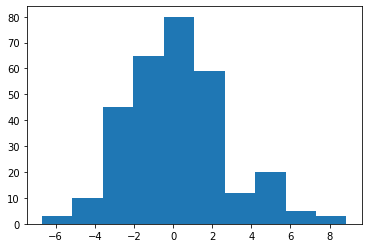

In [57]:
#残差の平均でヒストグラムを描く
plt.hist(data["res_avg"])
plt.show()

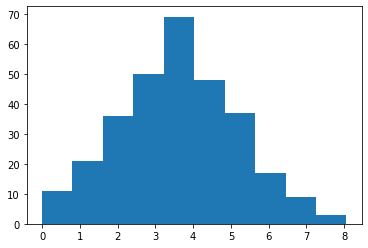

In [59]:
#残差の標準偏差でヒストグラムを描く
plt.hist(data["res_std"])
plt.show()

In [64]:
#ランキングの表示
data.sort_values("res_std",ascending=False).head(10)

,Player,PTS,MIN,res_avg,res_std
55,ジョーダン・フェイゾン,21.000000,33.887500,5.674460,8.058799
45,ジュリアン・マブンガ,19.909091,33.321636,4.871010,7.950477
53,ジョーダン・ハミルトン,20.851852,32.925556,6.014981,7.357585
282,金丸晃輔,16.163636,26.251818,4.717033,7.247037
71,ニック・ファジーカス,20.660714,29.979286,7.320552,7.066868
50,ジョシュ・ホーキンソン,15.808511,25.849362,4.566356,6.924338
60,ダバンテ・ガードナー,19.545455,29.911273,6.239843,6.619654
72,ニック・メイヨ,21.490909,33.622727,6.299874,6.565868
206,橋本拓哉,13.425000,29.599000,0.278024,6.546280
67,デモン・ブルックス,17.946429,30.751429,4.214017,6.522998


In [68]:
#残差の変動係数を算出
cv=[]
for avg,std in zip(data["res_avg"],data["res_std"]):
    cv.append(std/avg)

data["res_CV"]=pd.DataFrame(cv)

In [74]:
#残差の変動係数の絶対値でランキングを表示
#残差の変動係数の絶対値を算出
cv_abs=[]
for CV in data["res_CV"]:
    cv_abs.append(abs(CV))

data["res_CV_abs"]=pd.DataFrame(cv_abs)

In [76]:
#絶対値が大きい選手TOP10を表示
data.sort_values("res_CV_abs",ascending=False).head(10)

,Player,PTS,MIN,res_avg,res_std,res_CV,res_CV_abs
272,角野亮伍,3.461538,10.551538,-0.009302,3.699871,-397.740093,397.740093
134,古川孝敏,9.118644,21.765254,-0.048779,5.612122,-115.051980,115.051980
114,今村佳太,9.750000,22.753929,0.080329,4.522796,56.303359,56.303359
163,小酒部泰暉,6.521739,16.700217,-0.072639,4.025178,-55.413788,55.413788
279,野口大介,3.327586,10.155690,0.057837,2.835729,49.029485,49.029485
200,根來新之助,0.888889,5.362593,0.054040,2.484311,45.972096,45.972096
93,ルーク・エヴァンス,10.500000,24.697500,-0.157008,6.398616,-40.753495,40.753495
108,中野司,8.084746,19.377797,0.130154,4.495582,34.540402,34.540402
77,パブロ・アギラール,11.534483,26.157931,0.135574,4.631809,34.164416,34.164416
2,アイラ・ブラウン,14.092593,31.810185,-0.177669,6.045228,-34.025296,34.025296


In [77]:
#平均5点以上で絶対値が小さい選手TOP10を表示
data[data["PTS"]>=5].sort_values("res_CV_abs").head(10)

,Player,PTS,MIN,res_avg,res_std,res_CV,res_CV_abs
94,レイヴォンテ・ライス,19.980392,25.609608,8.860032,5.436965,0.613651,0.613651
87,ライアン・ケリー,21.061224,28.415102,8.515670,5.556057,0.652451,0.652451
66,デション・トーマス,16.600000,24.660000,5.962042,4.223586,0.708413,0.708413
149,大崎裕太,5.642857,24.272381,-4.798190,3.893109,-0.811370,0.811370
10,アンドレ・マレー,7.500000,14.970000,1.784575,1.606843,0.900406,0.900406
195,林翔太郎,5.259259,22.445741,-4.253852,3.839764,-0.902656,0.902656
300,鵤誠司,5.241379,21.414828,-3.748027,3.442284,-0.918426,0.918426
71,ニック・ファジーカス,20.660714,29.979286,7.320552,7.066868,0.965346,0.965346
57,ステヴァン・イェロヴァツ,18.846154,30.863077,5.057025,4.897302,0.968416,0.968416
90,リチャード・ソロモン,14.357143,21.599524,5.273911,5.256437,0.996687,0.996687


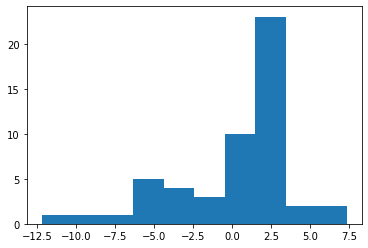

In [83]:
#変動係数が大きい選手（角野選手）の残差のヒストグラムを表示
plt.hist(boxscore[boxscore["Player"]=="角野亮伍"]["res"])
plt.show()

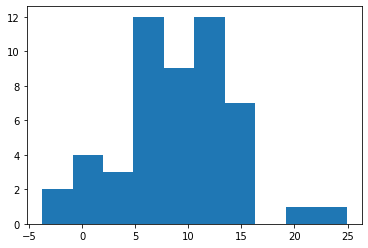

In [84]:
#変動係数が小さい選手（ライス選手）の残差のヒストグラムを表示
plt.hist(boxscore[boxscore["Player"]=="レイヴォンテ・ライス"]["res"])
plt.show()